### Test of data instantiation

In [1]:
import torch
from torch.utils.data import DataLoader 
import numpy as np
import matplotlib.pyplot as plt
import os
from torchmetrics import FBetaScore, Accuracy
import torchvision.transforms as T
from torchvision.transforms import functional as F

import src.dfmaker as dfmaker
import src.BWDatasets as BWDatasets

from paddleocr import PaddleOCR
import paddle


c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


### Ensure Reproducibility

In [2]:
seed = 115
generator = torch.Generator()
generator.manual_seed(seed)
np_generator = np.random.default_rng(seed=seed)

### Activate CUDA

In [3]:
device = torch.device('cpu')

# Make sure the notebook is deterministic if training on gpu
if torch.cuda.is_available():
    device = torch.device('cuda')
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False

print(f'Cuda availability is: {torch.cuda.is_available()}')  # Returns True if a GPU is available
print(f"Training on device {device}.")

Cuda availability is: True
Training on device cuda.


In [4]:
# Lyngøy
label_path_lyng = "dataset/datasets/lyngoy/ringcodes.csv"
image_path_lyng = "dataset/datasets/lyngoy/images"
bb_path_lyng = "dataset/datasets/lyngoy/labels"

# RF
label_path_rf = "dataset/datasets/rf/ringcodes.csv"
image_path_rf = "dataset/datasets/rf/images"
bb_path_rf = "dataset/datasets/rf/labels"

# Ringmerkingno
label_path_rno = "dataset/datasets/ringmerkingno/ringcodes.csv"
image_path_rno = "dataset/datasets/ringmerkingno/images"
bb_path_rno = "dataset/datasets/ringmerkingno/labels"

max_n_single = None
max_n_all = None
transform = T.Compose([
    T.Resize((224,112)),
    T.Lambda(lambda x: F.rotate(x, 270, expand=True))
])

df_lyng = dfmaker.make_dataframe(labels_path=label_path_lyng, img_path=image_path_lyng, bb_path=bb_path_lyng, max_n=max_n_single)
df_rf = dfmaker.make_dataframe(labels_path=label_path_rf, img_path=image_path_rf, bb_path=bb_path_rf, max_n=max_n_single)
df_rno = dfmaker.make_dataframe(labels_path=label_path_rno, img_path=image_path_rno, bb_path=bb_path_rno, max_n=max_n_single)
complete_df = dfmaker.combine_dfs([df_lyng, df_rf, df_rno])

exp_dataset = BWDatasets.TrainDataSet(df=complete_df, transform=transform, max_n=max_n_all)


In [5]:
def draw_image(img):
    img_uint8 = BWDatasets.tensor_to_numpy(img)
    plt.figure(figsize=(12,12))
    plt.imshow(img_uint8)
    plt.axis("off")
    plt.show()

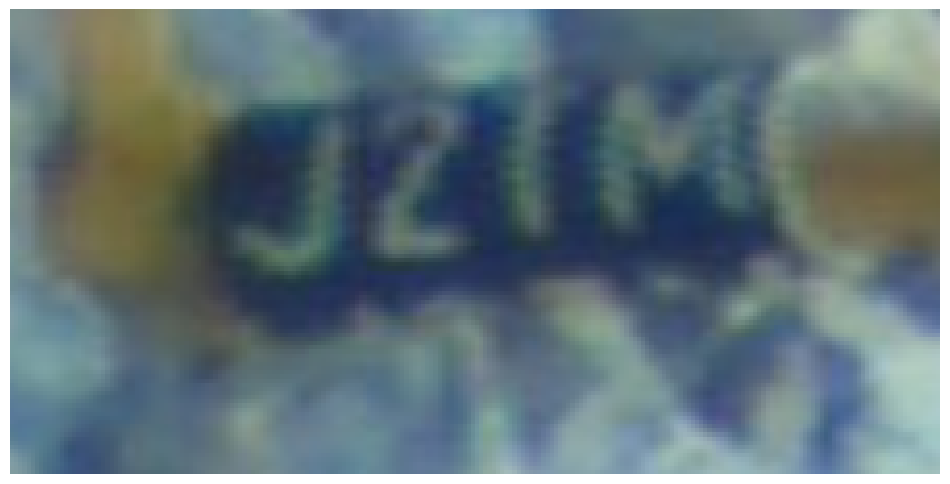

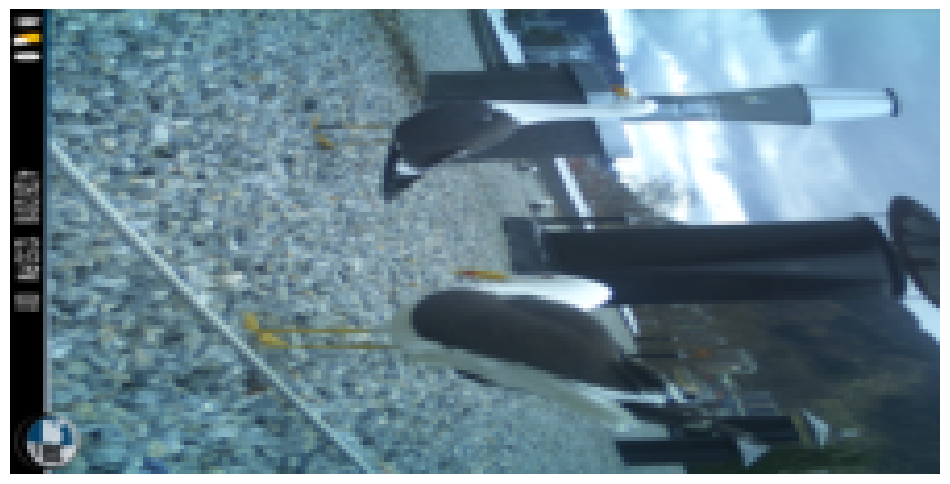

In [6]:
data = exp_dataset[0]

draw_image(data["ocr_image"])
draw_image(data["image"])


In [7]:
#stop



In [8]:
paddle.device.set_device("gpu:0")
ocr = PaddleOCR(lang="en", 
           use_doc_orientation_classify=True, 
           use_doc_unwarping=True, 
           use_textline_orientation=True, device='gpu')


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 1288.90it/s]
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 573.27it/s]
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 530.25it/s]
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00

In [9]:

exp_loader = DataLoader(dataset=exp_dataset, batch_size=64, shuffle=False, generator=generator)


In [10]:
def prediction(dataloader):
    preds = []
    targets = []
    count = 0
    for data in dataloader:
        count +=1
        print(f'Batch {count} of {len(dataloader)}')
        images = BWDatasets.tensor_to_numpy(data["ocr_image"])
        labels = data["label"][0]
        for i, image in enumerate(images):
            
            result = ocr.predict(image)

            pred = result[0]["rec_texts"]

            if not pred:
                pred = ['Not Found']

            preds.append(pred[0])

            label = labels[i]
            
            targets.append(label)

            # print("-------------------")
            # print(f'Prediction: {pred}')
            # print(f'Actual: {label}')

            # plt.figure(figsize=(4,2))
            # plt.imshow(image, cmap="gray")
            # plt.axis("off")
            # plt.show()
    return preds, targets


In [11]:
def evaluate_model(preds, labels):
    print(f'preds: {preds}')
    print(f'labels: {labels}')
    
    # Boolean mask for the predictions and the labels
    # Prediction = 1 if it is correct, 0 otherwise
    # Labels are always = to 1
    bin_preds = [int(pred == label) for pred, label in zip(preds, labels)]
    bin_labels = [1]*len(labels)

    preds_tensor, labels_tensor = torch.tensor(bin_preds), torch.tensor(bin_labels)
    fbeta = FBetaScore(task='binary', beta=0.5)
    acc = Accuracy(task='binary')

    print(f'Model F1 Score: {fbeta(preds_tensor, labels_tensor)}')
    print(f'Model Accuracy: {acc(preds_tensor, labels_tensor)}')
    # print(f'preds: {preds_tensor}')
    # print(f'labesl: {labels_tensor}')

In [12]:
preds, labels = prediction(exp_loader)


Batch 1 of 554
Batch 2 of 554
Batch 3 of 554
Batch 4 of 554
Batch 5 of 554
Batch 6 of 554
Batch 7 of 554
Batch 8 of 554
Batch 9 of 554
Batch 10 of 554
Batch 11 of 554
Batch 12 of 554
Batch 13 of 554
Batch 14 of 554
Batch 15 of 554
Batch 16 of 554
Batch 17 of 554
Batch 18 of 554
Batch 19 of 554
Batch 20 of 554
Batch 21 of 554
Batch 22 of 554
Batch 23 of 554
Batch 24 of 554
Batch 25 of 554
Batch 26 of 554
Batch 27 of 554
Batch 28 of 554
Batch 29 of 554
Batch 30 of 554
Batch 31 of 554
Batch 32 of 554
Batch 33 of 554
Batch 34 of 554
Batch 35 of 554
Batch 36 of 554
Batch 37 of 554
Batch 38 of 554
Batch 39 of 554
Batch 40 of 554
Batch 41 of 554
Batch 42 of 554
Batch 43 of 554
Batch 44 of 554
Batch 45 of 554
Batch 46 of 554
Batch 47 of 554
Batch 48 of 554
Batch 49 of 554
Batch 50 of 554
Batch 51 of 554
Batch 52 of 554
Batch 53 of 554
Batch 54 of 554
Batch 55 of 554
Batch 56 of 554
Batch 57 of 554
Batch 58 of 554
Batch 59 of 554
Batch 60 of 554
Batch 61 of 554
Batch 62 of 554
Batch 63 of 554
B

In [13]:
evaluate_model(preds=preds, labels=labels)


preds: ['J21M', 'Not Found', 'Not Found', 'JJ168', 'JJ168', 'Not Found', 'Not Found', 'Not Found', 'Not Found', '2350', 'Not Found', 'Not Found', 'Not Found', '1S000', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'LLTC', 'LLLTC', 'Not Found', 'JL512', 'JL503', 'JL512', '', 'Not Found', '公K', 'Not Found', 'Not Found', 'J1O5', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'LLLTC', 'Not Found', 'Not Found', 'Not Found', 'J236H', 'J236H', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'JL503', 'CDS', 'Not Found', 'Not Found', 'J236H', '36H', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'LLL7C', 'JL177', 'JL177', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', '3007', 'Not Found', 'JL503', 'Not Found', 'Not Found', 'Not Found', 'Not